<h1>Multi Layered Perceptron using JAX</h1>

In [2]:
import jax #import micrograd.engine as engine
import jax.numpy as jnp #import numpy as np
from jax import grad, jit, vmap, value_and_grad, tree_map, vjp
from jax import random as jrandom
import random
import matplotlib.pyplot as plt


This code implements a multi-layer perceptron (MLP) neural network using the JAX library. The MLP consists of three types of modules: Neuron, Layer, and MLP. The Neuron module represents a single neuron in a layer, the Layer module represents a layer of neurons, and the MLP module represents the entire neural network. The modules define methods to update their parameters using stochastic gradient descent (SGD).

In [3]:
class Module:

    def parameters(self):
        return []
    
    def update(self, grads):
        return []


class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [random.uniform(-1,1) for _ in range(nin)]
        self.b = random.uniform(-1,1)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return jax.nn.relu(act) if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def update(self, grads, learning_rate):
        # print("neuron")
        self.w = [x - g*learning_rate for x,g in zip(self.w, grads)]
        return self.parameters()

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        # print("p-layer")
        return [p for n in self.neurons for p in n.parameters()]
    
    def update(self, grads, learning_rate):
        # print("layer")
        return [p for n in self.neurons for p in n.update(grads, learning_rate)]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"
  
class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        # print("p-mlp")
        return [p for layer in self.layers for p in layer.parameters()]
    
    def update(self, grads, learning_rate):
        # print("mlp")
        return [p for layer in self.layers for p in layer.update(grads, learning_rate)]

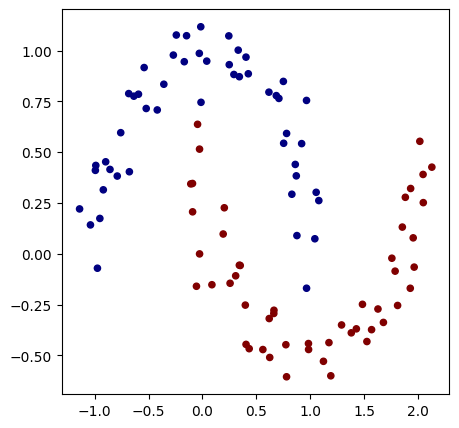

In [17]:
jrandom.PRNGKey(1337)
random.seed(1337)

# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5)) 
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

model = MLP(2, [16, 16, 1])

In [5]:
print(model.parameters())
print("number of parameters", len(model.parameters()))

[0.23550571390294128, 0.06653114721000164, -0.26830328150124894, 0.1715747078045431, -0.6686254326224383, 0.6487474938152629, -0.23259038277158273, 0.5792256498313748, 0.8434530197925192, -0.3847332240409951, 0.9844941451716409, -0.5901079958448365, 0.31255526637777775, 0.8246106857787521, -0.7814232047574572, 0.6408752595662697, -0.20252189189007108, -0.8693137391598071, 0.39841666323128555, -0.3037961142013801, -0.19282493884310759, 0.6032250931493106, 0.6001302646227185, 0.32749776568749045, 0.6650130652363544, 0.1889136153241595, -0.07813264062433589, 0.9151267732861252, 0.5914405264235476, -0.3725442040076463, 0.3810827422406471, 0.8301999957053683, -0.08568482691922008, -0.4702876239420326, -0.598037011209763, -0.8653994554527067, 0.05088685407468296, 0.23734644010332318, 0.15459549089529045, -0.9122391928398941, -0.18505999501786086, 0.30584552737905213, 0.23949109098065002, 0.35119774963171047, 0.26999576683073867, -0.6059558972032326, -0.4301483303818887, -0.09534359352124744,

The loss function for the MLP combines a max-margin loss and L2 regularization. It randomly selects a batch of data, computes the model's scores, and calculates the losses for each score. The total loss is the sum of the data and regularization losses.

In [21]:
# loss function
def loss(params): 
    batch_size = 100

    # Generate a random permutation of indices
    rng = jrandom.PRNGKey(0)
    ri = jrandom.permutation(rng, X.shape[0])

    # Select the first batch_size indices
    batch_indices = ri[:batch_size]
    Xb, yb = X[batch_indices], y[batch_indices]

    # forward the model to get scores
    inputs = [x for x in Xb]
    scores = list(map(model, inputs))
    # svm "max-margin" loss
    losses = [jax.nn.relu(1 + -yi*scorei) for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in params))
    total_loss = data_loss + reg_loss
    return total_loss


This code performs SGD optimization to update the MLP model's parameters iteratively for 100 epochs. The value_and_grad function from JAX computes the loss value and the gradients of the loss function with respect to the model's parameters. Then, the model.update method updates the parameters using the computed gradients and the current learning rate.

In [22]:
# optimization
for k in range(100):
    learning_rate = 1.0 - 0.9*k/100
    loss_val, grads = value_and_grad(loss)(model.parameters())
    model.update(grads, learning_rate)
    if k % 10 == 0:
      print(f"step {k} loss {loss_val}")

step 0 loss 1.1882131099700928
step 10 loss 1.1849803924560547
step 20 loss 1.1820565462112427
step 30 loss 1.179443120956421
step 40 loss 1.177135705947876
step 50 loss 1.175131916999817
step 60 loss 1.1734308004379272
step 70 loss 1.172031044960022
step 80 loss 1.1709331274032593
step 90 loss 1.170135498046875
